Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv
Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

 1.Загрузка данных

In [58]:
# load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
%matplotlib inline

In [59]:
PATH_TRAIN='Data/train.csv'
PATH_TEST='Data/test.csv'
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
test_df=test
print("Поехали, загрузка успешна!")

Поехали, загрузка успешна!


In [60]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [61]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [62]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [63]:
# Преобразуем явные Id > в строки
def optimizingId_df(df):
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    # healthcare_1
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    # lifesquare
    square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square'] -df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -\
                       df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()
    
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df.loc[df['LifeSquare'].isnull(), 'Square'] -\
    df.loc[df['LifeSquare'].isnull(), 'KitchenSquare'] -square_med_diff
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
# пройдемся по двум чтобы не забыть
optimizingId_df(test)
optimizingId_df(train)




In [64]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [65]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Оптимизация ресурсов по памяти

In [66]:
# функция оптимизации
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

In [67]:
train = optimizing_df(train)
test = optimizing_df(test)

In [68]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [69]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   object  
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

Вывод: улучшили использование памяти почти на порядок, в 8 раз...

2.Проверка данных на адекватность.

In [70]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839523,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315712,21.058718,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,10000.0,39.397549,77.430977,-8.508375,24.523744,34.078751,47.648065,7.480592e+03
KitchenSquare,10000.0,6.273300,28.561113,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776192,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119026,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


Разберемся с Rooms. Моя версия: количество д.б. [1,6]  

In [71]:
train.loc[train['Rooms'] > 6 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
377,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,19083,2,900.0,5,15,B,317265.312500,1,1,1
1454,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,264,0,900.0,0,1,B,78364.617188,1,1,1
8849,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,...,5648,1,30.0,2,4,B,172329.265625,1,1,1


In [72]:
test.loc[test['Rooms'] > 6 ]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
3398,1435,111,17.0,52.866108,32.528343,8.0,15,17.0,1987,0.093443,...,23,4635,5,3300.0,2,4,B,1,1,1


In [73]:
train.loc[train['Rooms'] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1397,12638,27,0.0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,...,3097,0,900.0,0,0,B,268394.750000,1,1,1
1981,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,900.0,0,1,B,302211.250000,1,1,1
2269,7317,27,0.0,41.790882,30.423265,0.0,13,0.0,1977,0.211401,...,1892,0,900.0,0,1,B,98129.976562,1,1,1
3911,770,28,0.0,49.483501,38.115883,0.0,16,0.0,2015,0.118537,...,6207,1,1183.0,1,0,B,217009.343750,1,1,1
4366,456,6,0.0,81.491447,70.123833,0.0,4,0.0,1977,0.243205,...,1564,0,540.0,0,0,B,212864.796875,1,1,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,469,0,900.0,0,0,B,126596.945312,1,1,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,8429,3,900.0,3,9,B,158998.109375,1,1,1
8834,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,...,1892,0,900.0,0,1,B,219281.921875,1,1,1


In [74]:
test.loc[test['Rooms']==0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
2406,3343,58,0.0,116.824203,113.692421,0.0,3,3.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,1,1,1
2524,10729,27,0.0,76.345154,42.820797,12.0,14,0.0,1977,0.017647,...,2,469,0,900.0,0,0,B,1,1,1


In [75]:
train.loc[train['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
6977,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,...,6398,141,1046.0,3,23,B,133529.687500,1,1,1
4262,28,9,2.0,604.705994,592.338379,1.0,17,18.0,1977,0.161532,...,5648,1,30.0,2,4,B,187717.250000,1,1,1
4690,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,3889,6,705.0,3,6,B,90470.429688,1,1,1
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,7010,5,4508.0,3,7,B,455264.875000,1,0,1
1981,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,900.0,0,1,B,302211.250000,1,1,1
9910,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,14892,4,900.0,1,4,B,528560.500000,1,1,1


In [76]:
def df_fix_room(df):
    df.loc[df['Rooms'] > 6 , 'Rooms'] = 1
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

def manual_fix_room_train(df):
    df.loc[df['Id']=='7917','Rooms']=4
    df.loc[df['Id']=='11602','Square']=64.1065186
    df.loc[df['Id']=='11602','LifeSquare']=43.8163208
    df.loc[df['Id']=='28','Square']=60.4705994
    df.loc[df['Id']=='28','LifeSquare']=59.2338379
    df.loc[df['Id']=='2307','Square']=41.0639740
    df.loc[df['Id']=='2307','LifeSquare']=20.9425171 
    return df;       

In [77]:
train=manual_fix_room_train(train)
train.loc[train['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,...,7010,5,4508.0,3,7,B,455264.875,1,0,1
1981,7917,27,4.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,1892,0,900.0,0,1,B,302211.250,1,1,1
9910,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,...,14892,4,900.0,1,4,B,528560.500,1,1,1


In [78]:
import warnings
warnings.filterwarnings('ignore')


In [79]:
def df_fix_square_manual(df):
   # df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    df.loc[df['KitchenSquare'] > 30,'KitchenSquare']=30
    df.loc[df['Square'] < 10,'Square']=10*df['Square']
    df.loc[df['LifeSquare'] < 10,'Square']=10*df['LifeSquare']
    return df

In [80]:
def df_fix_square(df):
    df.loc[df['LifeSquare'] > df['Square']-df['KitchenSquare'], 'LifeSquare'] = df['Square']-df['KitchenSquare']
    df.loc[df['LifeSquare'] < 0, 'LifeSquare'] = df['Square']-df['KitchenSquare'] 
    return df

In [81]:
import random
def df_fix_hf(df):
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    np.random.seed(27)
    floor_outliers = df[df['Floor'] > df['HouseFloor']].index
    print(len(floor_outliers))
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    return df
train= df_fix_hf(train)

1610


In [82]:
# train=df_fix_square_manual(train)
# train=df_fix_square(train)
train.loc[train['LifeSquare'] < 0]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
5888,16593,52,2.0,64.859245,-8.508375,62.0,15,17.0,1977,0.371149,...,7065,1,750.0,2,5,B,185993.46875,1,1,1


In [83]:
#df_fix_square_manual(train)
train.loc[train['Square'] < train['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,...,168,0,900.0,0,0,B,95338.195312,1,1,1
44,10521,38,3.0,104.211395,106.340401,0.0,4,13.0,2017,0.060753,...,2787,2,520.0,0,7,B,435462.062500,1,1,1
52,2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,...,264,0,900.0,0,1,B,199215.453125,1,1,1
123,8753,25,3.0,85.952309,89.803749,1.0,1,3.0,2017,0.069753,...,13670,4,900.0,1,11,B,309688.593750,1,1,1
153,9870,62,1.0,51.831474,53.491302,1.0,1,1.0,2015,0.072158,...,629,1,900.0,0,0,A,131797.468750,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,...,6398,141,1046.0,3,23,B,126281.140625,1,1,1
9889,12918,23,2.0,51.440464,53.134243,51.0,3,17.0,2017,0.005767,...,388,0,900.0,0,0,B,88150.015625,1,1,1
9895,2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,...,469,0,900.0,0,0,B,234194.843750,1,1,1
9902,14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,...,6856,84,1940.0,2,5,B,381937.406250,1,1,1


In [84]:
train.loc[train['KitchenSquare'] > 30]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
227,16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,...,10418,9,900.0,1,9,B,370148.625000,1,1,1
551,1315,6,1.0,48.128113,45.023533,48.0,1,1.0,2013,0.243205,...,1564,0,540.0,0,0,B,146950.906250,1,1,1
1064,14656,62,1.0,47.100719,46.447960,2014.0,1,1.0,2014,0.072158,...,629,1,900.0,0,0,A,108337.484375,1,1,0
1077,9690,27,1.0,40.081043,37.834965,37.0,18,19.0,2019,0.211401,...,1892,0,900.0,0,1,B,93218.648438,1,1,1
1369,2371,27,2.0,68.841072,64.234955,66.0,2,2.0,2014,0.017647,...,469,0,900.0,0,0,B,189244.250000,1,1,1
1455,12507,54,2.0,79.810532,79.578964,78.0,10,15.0,2014,0.006076,...,5285,0,645.0,6,6,B,438708.718750,1,1,1
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,...,3369,24,4129.0,0,3,B,261125.671875,1,1,1
1867,3267,58,3.0,138.980820,138.004593,43.0,2,2.0,1977,0.437885,...,5735,3,1084.0,0,5,B,169528.890625,1,1,1
2916,12390,72,3.0,97.490677,99.323555,96.0,22,25.0,2019,0.210473,...,2398,2,1994.0,3,0,B,445074.968750,1,1,1
2969,7441,62,3.0,114.734474,112.589081,112.0,3,3.0,2015,0.072158,...,629,1,900.0,0,0,A,315245.531250,1,1,0


Обработка HouseYear

In [85]:
train.loc[train['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,...,6141,10,262.0,3,6,B,254084.531250,1,1,1
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,...,4756,16,2857.0,5,8,B,243028.609375,1,1,1


In [86]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

3.Обработка данных

In [87]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import r2_score as r2

In [88]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Пример  на занятии
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

mu = 214138.86 and sigma = 92867.65


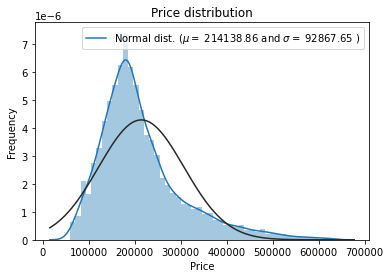

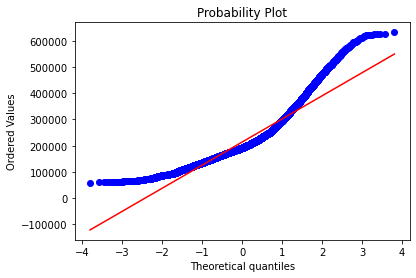

In [89]:
# нормальное распределение
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

mu = 214138.86 and sigma = 92867.65


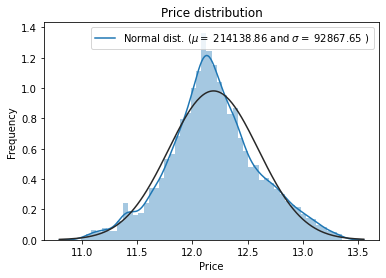

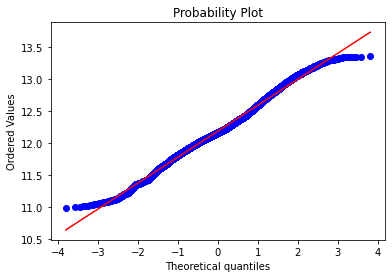

In [90]:
#Log distribution of the target variable
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

<AxesSubplot:>

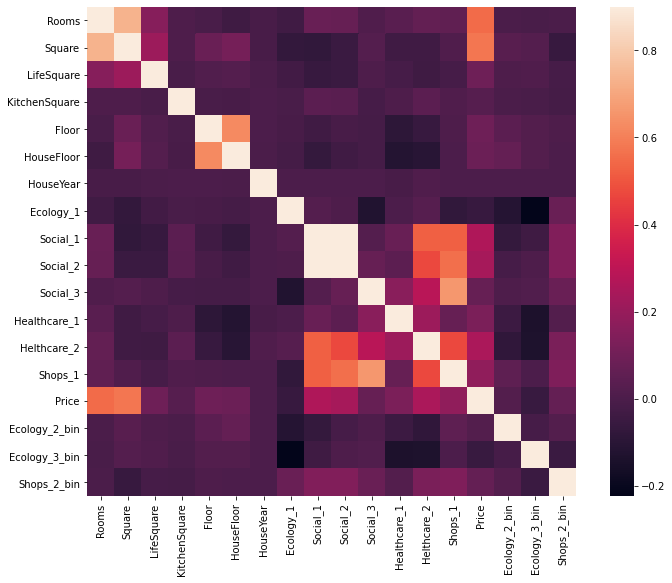

In [91]:
#Data Correlation
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

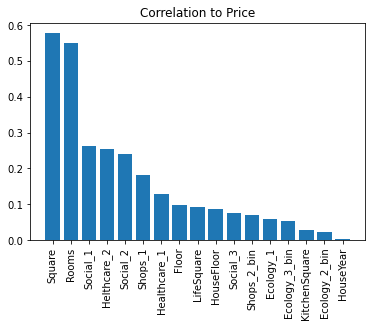

In [92]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [93]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.937500,1,1,1
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.437500,1,1,1
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.906250,1,1,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.234375,1,1,1
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531250,1,1,1


Cluster

In [94]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = df_fix_hf(df)
#     df = prepare_lifesquare(df)
#     df = fillna_life_square(df)
    df = pd.get_dummies(df)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

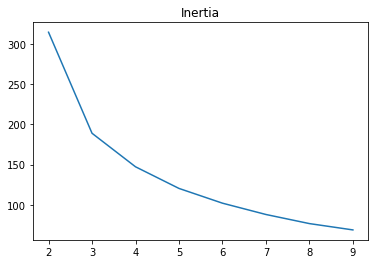

In [95]:
scaler = MinMaxScaler()
train_cluster = train.copy()
train_cluster = df_fix_house_year_manual(train_cluster)
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=83)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

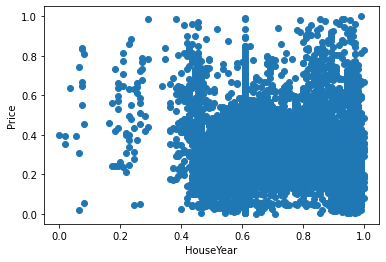

In [96]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

Моделирование

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [98]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Ecology_2_bin',
       'Ecology_3_bin', 'Shops_2_bin'],
      dtype='object')


In [99]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [100]:
train[features].head()

,Square,Rooms,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,LifeSquare,HouseFloor,Social_3,Shops_2_bin,Ecology_1,Ecology_3_bin,KitchenSquare,Ecology_2_bin,HouseYear
0,47.981560,2.0,33,0,7976,11,900.0,7,29.442751,9.0,5,1,0.089040,1,6.0,1,1969
1,65.683640,3.0,46,1,10309,16,240.0,7,40.049541,9.0,1,1,0.000070,1,8.0,1,1978
2,44.947952,2.0,34,1,7759,3,229.0,8,29.197611,12.0,0,1,0.049637,1,0.0,1,1968
3,53.352982,2.0,23,0,5735,5,1084.0,8,52.731510,17.0,3,1,0.437885,1,9.0,1,1977
4,39.649193,1.0,35,2,5776,4,2078.0,11,23.776169,12.0,1,1,0.012339,1,7.0,1,1976


In [101]:
models_dict = {}

In [102]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

target_name = 'Price'

In [103]:

X = train[feature_names]
y = train[target_name]
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=83)

In [104]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

X_train.describe().transpose()

0
0


,count,mean,std,min,25%,50%,75%,max
Square,7000.0,55.821518,19.360342,-85.083755,41.657870,52.310665,65.594231,275.645294
Rooms,7000.0,1.890000,0.817137,1.000000,1.000000,2.000000,2.000000,6.000000
Social_1,7000.0,24.673429,17.560011,0.000000,6.000000,25.000000,36.000000,74.000000
Helthcare_2,7000.0,1.315429,1.503320,0.000000,0.000000,1.000000,2.000000,6.000000
Social_2,7000.0,5338.691857,4001.610512,168.000000,1564.000000,5285.000000,7287.000000,19083.000000
Shops_1,7000.0,4.207143,4.764307,0.000000,1.000000,3.000000,5.000000,23.000000
Healthcare_1,7000.0,1022.330566,741.469055,0.000000,830.000000,900.000000,990.000000,4849.000000
Floor,7000.0,7.396286,5.013786,1.000000,3.000000,6.000000,10.000000,42.000000
LifeSquare,7000.0,38.096588,18.463278,-115.083755,24.597156,33.862762,47.419139,233.949310
HouseFloor,7000.0,13.015285,6.432494,1.000000,9.000000,14.000000,17.000000,117.000000


In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 5553 to 2130
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         7000 non-null   float32
 1   Rooms          7000 non-null   float32
 2   Social_1       7000 non-null   uint8  
 3   Helthcare_2    7000 non-null   uint8  
 4   Social_2       7000 non-null   uint16 
 5   Shops_1        7000 non-null   uint8  
 6   Healthcare_1   7000 non-null   float32
 7   Floor          7000 non-null   float32
 8   LifeSquare     7000 non-null   float32
 9   HouseFloor     7000 non-null   float32
 10  Social_3       7000 non-null   uint8  
 11  Shops_2_bin    7000 non-null   uint8  
 12  Ecology_1      7000 non-null   float32
 13  Ecology_3_bin  7000 non-null   uint8  
 14  KitchenSquare  7000 non-null   float32
 15  Ecology_2_bin  7000 non-null   uint8  
 16  HouseYear      7000 non-null   uint16 
dtypes: float32(8), uint16(2), uint8(7)
memory usage: 

In [106]:
#rf_model = RandomForestRegressor(max_depth=10, min_samples_split=100, n_estimators=5000, n_jobs=-2, random_state=83)
rf_model = GradientBoostingRegressor(alpha=0.999, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                        #  min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.000001, n_estimators=1000,
                          n_iter_no_change=None, 
                          random_state=83, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
rf_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.999, learning_rate=0.01, max_depth=8,
                          min_weight_fraction_leaf=1e-06, n_estimators=1000,
                          random_state=83)

In [107]:
# %%time
# params = {'n_estimators':[600, 800, 1000], 
#           'max_depth':[7, 10, 12,15],
#          'alpha':[0.9,0.999]}

# gs = GridSearchCV(rf_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=83, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)
# res = pd.DataFrame(gs.cv_results_)
# res.head(24)

Train R2:	0.954
Test R2:	0.736


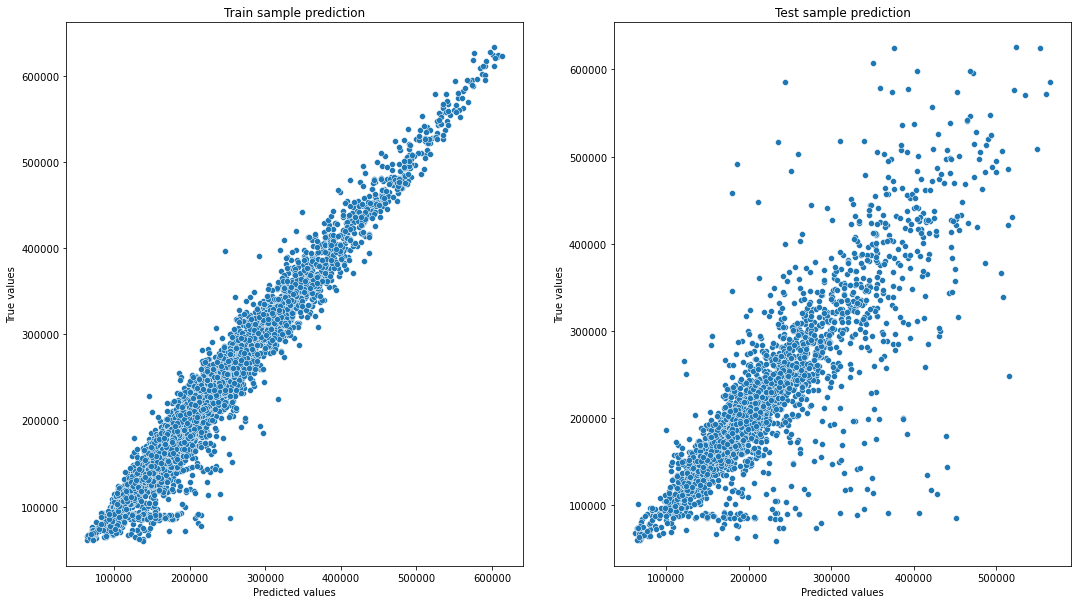

In [108]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [109]:
# from sklearn.model_selection import train_test_split, cross_val_score
# cv_score = cross_val_score(
#     rf_model,
#     X.fillna(-9999),
#     y, scoring='r2',
#     cv=KFold(n_splits=5, shuffle=True, random_state=83)
# )
# cv_score

In [110]:
# cv_score.mean(), cv_score.std()

In [111]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Square,0.378109
4,Social_2,0.130572
1,Rooms,0.083434
2,Social_1,0.072463
10,Social_3,0.071958
12,Ecology_1,0.049568
8,LifeSquare,0.045208
16,HouseYear,0.043270
9,HouseFloor,0.029217
14,KitchenSquare,0.026422


In [112]:
X_train.head()

,Square,Rooms,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,LifeSquare,HouseFloor,Social_3,Shops_2_bin,Ecology_1,Ecology_3_bin,KitchenSquare,Ecology_2_bin,HouseYear
5553,95.970757,3.0,23,0,5735,5,1084.0,2.0,93.323296,3.0,3,1,0.437885,1,1.0,1,1977
4625,53.088524,2.0,1,0,388,0,900.0,1.0,53.088524,1.0,0,1,0.005767,1,0.0,1,2017
4958,79.499809,3.0,46,3,7960,11,350.0,3.0,48.359146,16.0,6,1,0.135650,1,10.0,1,1984
1521,55.295654,2.0,5,0,1564,0,540.0,12.0,42.928036,17.0,0,1,0.243205,1,1.0,1,1977
677,76.248711,2.0,2,0,629,0,900.0,1.0,63.881096,1.0,1,0,0.072158,1,1.0,1,1977


In [113]:
y_train.head()

5553    222643.171875
4625     82733.312500
4958    394195.843750
1521    150469.937500
677     174685.750000
Name: Price, dtype: float32

Отправка в файл

In [114]:
test_features = list(X_train.columns)

In [115]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Square         5000 non-null   float32
 1   Rooms          5000 non-null   float32
 2   Social_1       5000 non-null   uint8  
 3   Helthcare_2    5000 non-null   uint8  
 4   Social_2       5000 non-null   uint16 
 5   Shops_1        5000 non-null   uint8  
 6   Healthcare_1   5000 non-null   float32
 7   Floor          5000 non-null   uint8  
 8   LifeSquare     5000 non-null   float32
 9   HouseFloor     5000 non-null   float32
 10  Social_3       5000 non-null   uint8  
 11  Shops_2_bin    5000 non-null   uint8  
 12  Ecology_1      5000 non-null   float32
 13  Ecology_3_bin  5000 non-null   uint8  
 14  KitchenSquare  5000 non-null   float32
 15  Ecology_2_bin  5000 non-null   uint8  
 16  HouseYear      5000 non-null   uint16 
dtypes: float32(7), uint16(2), uint8(8)
memory usage: 195

In [116]:
test = data_prepare(test)
test['Price'] = rf_model.predict(test[test_features])

792


In [117]:
test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,DistrictId_97,DistrictId_98,DistrictId_99,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,11,2748,...,0,0,0,0,1,0,1,0,1,162233.133156
1,2.0,69.263184,56.875797,1.0,1,1.0,1977,0.075779,6,1437,...,0,0,0,0,1,0,1,0,1,204601.278716
2,1.0,13.597818,1.597818,12.0,2,5.0,1909,0.000000,30,7538,...,0,0,0,0,1,0,1,0,1,218631.390306
3,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,23,4583,...,0,0,0,0,1,0,1,0,1,339635.468993
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,...,0,0,0,0,1,0,1,1,0,139240.895428


In [118]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,...,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263184,56.875797,1.0,1,1.0,1977,0.075779,...,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,13.597818,1.597818,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,900.0,0,0,A,1,1,0


In [119]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = test["Price"]
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"
pred_df.to_csv("AleshkevichAA_predictions.csv", index=False)